# DNA Embedding Analysis

This notebook explores the embedding quality of sequences from both pretrained and finetuned DNABERT models.

In [1]:
import bootstrap

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import tf_utils as tfu
import wandb

In [3]:
strategy = tfu.strategy.gpu(0)

2022-05-12 02:40:38.150916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 02:40:38.151134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 02:40:38.157097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 02:40:38.157398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 02:40:38.157647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

## Weights & Biases

In [54]:
PROJECT = "deep-learning-dna"
MODEL_ARTIFACTS = {
	"pretrained-128dim": f"{PROJECT}/dnabert-pretrain:128dim",
	"pretrained-64dim": f"{PROJECT}/dnabert-pretrain:64dim",
	"finetuned": f"{PROJECT}/dnabert-finetune-autoencoder:v0"
}

Here we get a public W&B API instance

In [55]:
api = wandb.Api()

Using the API instance, we can pull the dataset and model artifacts we wish to analyze.

In [56]:
dataset_path = api.artifact(f"{PROJECT}/dnasamples:v1").download()
dataset_path

wandb: Downloading large artifact dnasamples:v1, 328.84MB. 63 files... Done. 0:0:0


'./artifacts/dnasamples:v1'

In [57]:
model_artifact_paths = {}
for name, artifact in MODEL_ARTIFACTS.items():
	model_artifact_paths[name] = api.artifact(artifact).download()

wandb: Downloading large artifact dnabert-finetune-autoencoder:v0, 83.72MB. 4 files... Done. 0:0:0


## DNABERT Models

In [58]:
from common.models.dnabert import DnaBertPretrainModel, DnaBertAutoencoderModel, DnaBertEncoderModel

Load the models from the artifacts.

In [67]:
models = {}
with strategy.scope():
	for name, path in model_artifact_paths.items():
		basename = os.path.basename(path)
		if "dnabert-pretrain" in basename:
			models[name] = DnaBertEncoderModel(DnaBertPretrainModel.load(path).base)
		elif "dnabert-finetune" in basename:
			models[name] = DnaBertAutoencoderModel.load(path).encoder

dnabert-pretrain:v1
dnabert-pretrain:v2
dnabert-finetune-autoencoder:v0


Since there will be some configuration info we'll need to extract from the models, we will store a
reference to the base DNABERT model for quick access.

In [106]:
dnabert_base = list(models.values())[0].base

## DNA Samples

In [68]:
from common.data import find_shelves, DnaKmerSequenceGenerator

We first locate the samples that we wish to analyze. Here we specify to use the testing samples
which were not seen during training.

In [69]:
SAMPLE_PATH = os.path.join(dataset_path, "test")

In [70]:
sample_files = find_shelves(SAMPLE_PATH)
sample_files

['fall_2016-10-07',
 'fall_2017-10-13',
 'spring_2016-04-22',
 'spring_2017-05-02',
 'spring_2018-04-23',
 'spring_2019-05-14',
 'spring_2020-05-11']

### Subsamples

In [71]:
NUM_SUBSAMPLES_PER_SAMPLE = 10
SUBSAMPLE_SIZE = 1000
SEQUENCE_LENGTH = dnabert_base.length
KMER = dnabert_base.kmer

In [72]:
rng = np.random.default_rng()

In [78]:
with strategy.scope():
	embedded_subsamples = {name: {} for name in models}
	for sample_file in sample_files:
		# Remove the prefix path from the sample file
		path = os.path.join(SAMPLE_PATH, sample_file)

		# For now, use a DNA kmer-sequence generator to generate subsamples.
		generator = DnaKmerSequenceGenerator([path], SEQUENCE_LENGTH, KMER, SUBSAMPLE_SIZE,
											NUM_SUBSAMPLES_PER_SAMPLE, rng=rng)

		# Generate the embedded subsamples
		for name, model in models.items():
			embedded_subsamples[name][sample_file] = [model(subsample) for subsample in generator]

## General Statistics

In [80]:
SAMPLE_FILE = sample_files[0]
SUBSAMPLE_INDEX = 0

In [75]:
encoded_subsamples = {}
for name, model in models.items():
	encoded_subsamples[name] = model()
pretrained_subsample = pretrained_samples[sample_files[SAMPLE_INDEX]][SUBSAMPLE_INDEX]
finetuned_subsample = finetuned_samples[sample_files[SAMPLE_INDEX]][SUBSAMPLE_INDEX]

In [84]:
for model_name, subsamples in embedded_subsamples.items():
	print(f"{model_name} subsample min: {np.min(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX])}")

pretrained-128dim subsample min: -10.168787956237793
pretrained-64dim subsample min: -9.130172729492188
finetuned subsample min: -15.893312454223633


In [85]:
for model_name, subsamples in embedded_subsamples.items():
	print(f"{model_name} subsample max: {np.max(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX])}")

pretrained-128dim subsample max: 12.428179740905762
pretrained-64dim subsample max: 7.057840347290039
finetuned subsample max: 16.37104034423828


In [86]:
for model_name, subsamples in embedded_subsamples.items():
	print(f"{model_name} subsample mean: {np.mean(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX])}")

pretrained-128dim subsample mean: -0.027171200141310692
pretrained-64dim subsample mean: -0.0927366390824318
finetuned subsample mean: 0.04373675212264061


In [87]:
for model_name, subsamples in embedded_subsamples.items():
	print(f"{model_name} subsample STD: {np.std(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX])}")

pretrained-128dim subsample STD: 2.684875249862671
pretrained-64dim subsample STD: 2.084211587905884
finetuned subsample STD: 3.814985990524292


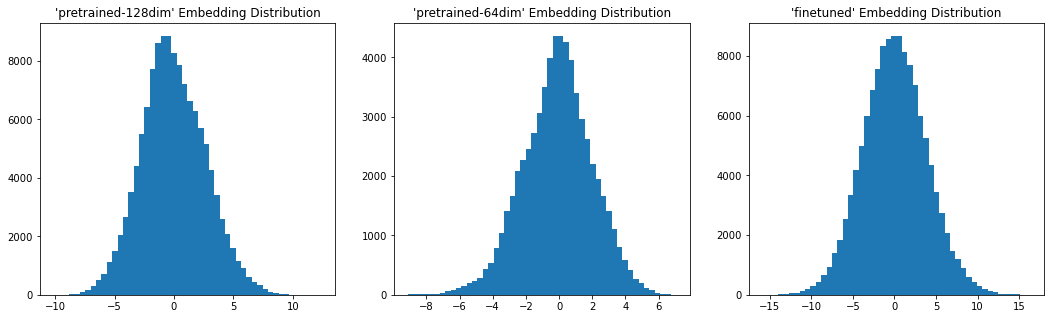

In [89]:
plt.figure(figsize=(6*len(models), 5))
for i, (model_name, subsamples) in enumerate(embedded_subsamples.items()):
	plt.subplot(1, len(models), i+1)
	plt.hist(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX].numpy().flatten(), bins=50)
	plt.title(f"'{model_name}' Embedding Distribution")
plt.show()

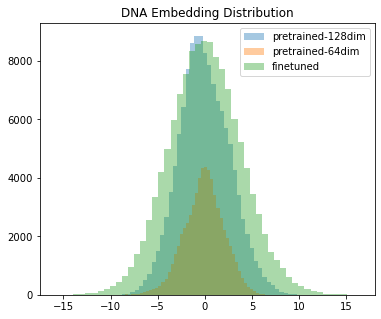

In [92]:
plt.figure(figsize=(6, 5))
for model_name, subsamples in embedded_subsamples.items():
	plt.hist(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX].numpy().flatten(), bins=50, alpha=0.4)
plt.legend(list(models.keys()))
plt.title("DNA Embedding Distribution")
plt.show()

## MDS

In [35]:
WORKERS = 24
SEED = 0

In [36]:
from scipy.spatial import KDTree
from common.metrics import chamfer_distance_matrix, mds, mds_stress_analysis

In order to increase the performance of Chamfer distance, the samples can be converted to KD-trees,
allowing us to compute the chamfer distance in ~O(nlogn) rather than O(n^2). The following cell
creates a concatenated list of KD-trees for each model-subsample group.

In [95]:
sample_trees = {name: [] for name in models}
for model_name, subsamples in embedded_subsamples.items():
	for sample_name in subsamples:
		sample_trees[model_name] += [KDTree(sample) for sample in subsamples[sample_name]]

Using the KD-trees, this next cell computes the chamfer distance matrices for each model group.

In [97]:
dist_mats = {}
for model_name, trees in sample_trees.items():
	dist_mats[model_name] = chamfer_distance_matrix(trees, workers=WORKERS)

With the distance matrices, the following cell computes the MDS for each distance matrix.

In [101]:
mds_pcas = {}
for model_name, dist_matrix in dist_mats.items():
	pca, _ = mds(dist_matrix, seed=SEED)
	mds_pcas[model_name] = pca.reshape((-1, NUM_SUBSAMPLES_PER_SAMPLE, 2))

Finally we can create a 2D plot of the resulting MDS groups to get an idea of DNA subsample
similarities.

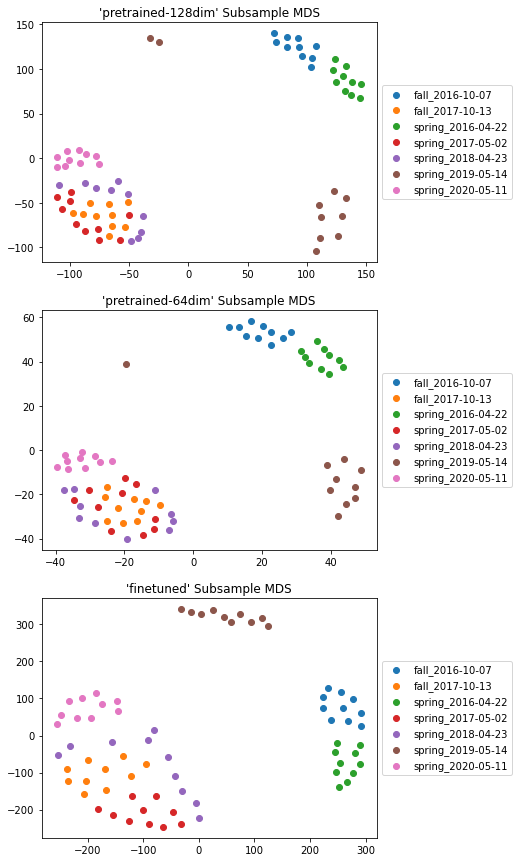

In [105]:
plt.figure(figsize=(6, 5*len(models)))
for i, (model_name, pca) in enumerate(mds_pcas.items()):
	plt.subplot(len(models), 1, i+1)
	for subsample in pca:
		plt.scatter(*subsample.T)
	plt.legend(sample_files, loc="center left", bbox_to_anchor=(1, 0.5))
	plt.title(f"'{model_name}' Subsample MDS")

### Stress Analysis

In [107]:
DIMS = dnabert_base.embed_dim

In [110]:
stress_cdfs = {}
for model_name, dist_matrix in dist_mats.items():
	_, stress_cdfs[model_name] = mds_stress_analysis(dist_matrix, DIMS, seed=SEED, workers=WORKERS)

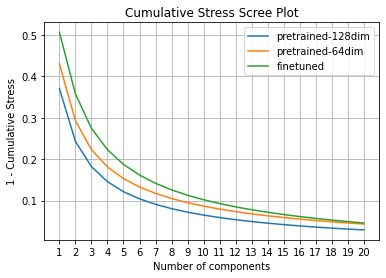

In [112]:
LIMIT = 20
plt.figure()
x_ticks = 1 + np.arange(len(list(stress_cdfs.values())[0][:LIMIT]))
for model_name, stress_cdf in stress_cdfs.items():
	plt.plot(x_ticks, stress_cdf[:LIMIT])
plt.xticks(x_ticks)
plt.xlabel("Number of components")
plt.ylabel("1 - Cumulative Stress")
plt.legend(list(models.keys()))
plt.title("Cumulative Stress Scree Plot")
plt.grid()
plt.show()